This notebook walks through a basic example of Gaussian Process classification from scratch. Theory and code included. This tutorial follows mostly Rasmussen and Williams as well as sections in Bishops PRML pertaining to the subject.

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib
from scipy.optimize import minimize

# Helpful Functions 

In [2]:
# This class interacts with PyTorch's DataLoader.
class data(Dataset):
    
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    if len(self.X) != len(self.Y):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
    _x = self.X[index].unsqueeze(dim=0)
    _y = self.Y[index].unsqueeze(dim=0)

    return _x, _y


# Gaussian Process Squared Exponential Kernel
def K(X,Y,ℓ,w,σn = 1e-10):
    
    scaledX = X/(np.sqrt(2)*ℓ)
    scaledY = Y/(np.sqrt(2)*ℓ)
    R = torch.cdist(scaledX, scaledY, p=2)**2
    
    return w*torch.exp(-R)+σn*torch.eye(len(X))

In [3]:
# Importing the MNIST dataset. 
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

# Defines which two numbers to try and classify,
# This implementation is a binary classifier.
num1 = 2
num2 = 6

# Exclude all numbers in the lables that are not num1 or num2
labels = mnist_trainset.targets[((mnist_trainset.targets == num1) | (mnist_trainset.targets == num2))]

# Replace the labels with 0 and 1 for ease of training
labels[labels == num1] = 0
labels[labels == num2] = 1

# Exclude all numbers in the inputs that are not num1 or num2
inputs = mnist_trainset.data[((mnist_trainset.targets == num1) | (mnist_trainset.targets == num2))]

# Rescale the inputs to be [-1,1]
inputs = (inputs-(127.5))/127.5

# Display the first few samples of the Dataset

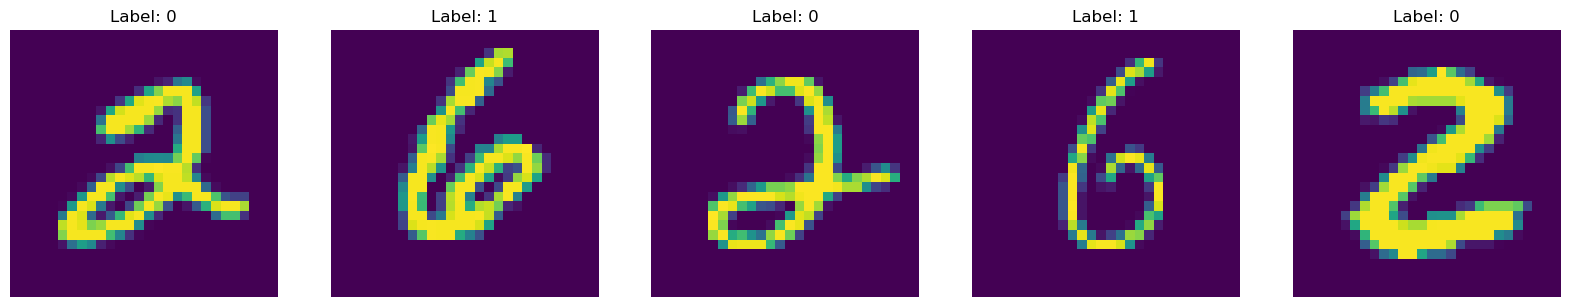

In [4]:
fig,ax  = plt.subplots(1,5,figsize=(20,10))
for i in range(5):
    ax[i].imshow(inputs[i])
    ax[i].set_title("Label: " + str(labels[i].item()))
    ax[i].axis('off')

In [5]:
# The Dataloader class handles all the shuffles for you
# The batch size determine how many samples are shown to the GP, as well as the test dataset size. 
loader = DataLoader(data(inputs,labels), batch_size=150,shuffle=True)

The fundamental assumption of GP classification is that of the latent function $\boldsymbol{f}$. Comaparing this to regular logistic classification makes it quite obvious. In logistic regression we take a set of weights $\boldsymbol{w}$ and dot product it with our input $\boldsymbol{\Phi}$ which is the design matrix of our input data. With this dotted signal, we can then shove it through a sigmoid to attain a proabability of the output. Rather than just fitting the parameters $\boldsymbol{w}$, GP classification assumes the input to the sigmoid is distributed via GP prior. An example of this can be seen below. First I created a grid over the input space, then used that to attain the kernel matrix. Second I sampled a multivariate Gaussian with covariance $K(X,X)$ to get the samples in function space $\boldsymbol{f}$. With this you can simply squeeze it through a sigmoid to attain probabilities. This is the forward problem for GP classification, it parallels with randomly sampling a set of weights in logistic regression according to some prior distribution on them. 

C:\Users\hsull\AppData\Local\Temp\ipykernel_16228\1858434126.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  Fs = torch.from_numpy(np.random.multivariate_normal(np.zeros(len(Kxx)),Kxx.numpy()))


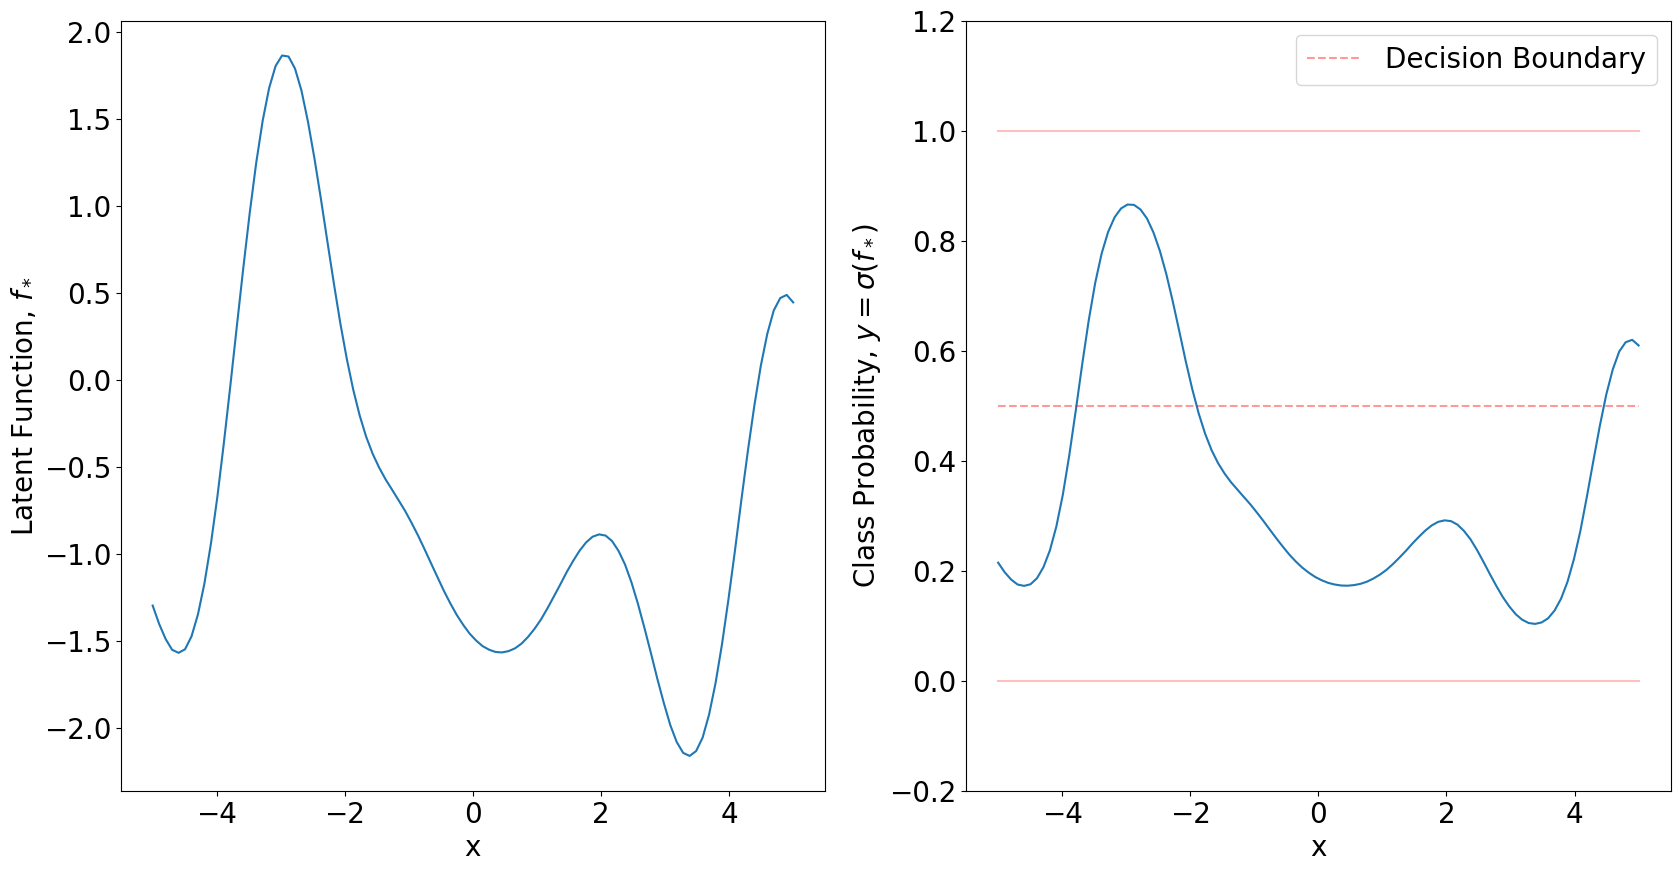

In [6]:
matplotlib.rcParams.update({'font.size': 20})
Xs = torch.linspace(-5,5,100).unsqueeze(dim=0).T
Kxx = K(Xs,Xs,1,2.35,0) 
Fs = torch.from_numpy(np.random.multivariate_normal(np.zeros(len(Kxx)),Kxx.numpy()))

fig,ax = plt.subplots(1,2,figsize=(20,10))

ax[0].plot(Xs,Fs)
ax[0].set_ylim(min(Fs) - 0.2, max(Fs) + 0.2)
ax[0].set_ylabel('Latent Function, $f_*$')
ax[0].set_xlabel('x')
ax[1].plot(Xs,torch.sigmoid(Fs))
ax[1].set_ylim(- 0.2, 1.2)
ax[1].set_ylabel('Class Probability, $y = \sigma(f_*)$')
ax[1].set_xlabel('x')
ax[1].plot(Xs,np.zeros(len(Xs)),alpha = 0.25,color='r')
ax[1].plot(Xs,np.ones(len(Xs)),alpha = 0.25,color='r')
ax[1].plot(Xs,0.5*np.ones(len(Xs)),alpha = 0.4,color='r',linestyle='dashed',label='Decision Boundary')
plt.legend()
plt.show()

Within GP classification we can treat the function $\boldsymbol{f}$ as *latent*. In that we dont observe the function values. These types of functions/parameters gain the title of *nuisance*. The goal is not to nescicarly know the nuisance, but it does help formulate the problem in a more simple manner. The end goal will be to integrate out the nuisance and attain it's expectation. Consider the dataset at hand, MNIST. We don't know what function maps us from the image vector to its feature space $\boldsymbol{f}$. However, we do know what the labels on the numbers are. This puts us in an interesting position comapared to regular GP regression. We have to inform our function values $\boldsymbol{f}$ through only observations of their category $\boldsymbol{y}$. The first step in computing a posterior on the predictions $\boldsymbol{\pi}_ *$ will be to attain the latent function values of the new datapoint $\boldsymbol{x}_*$. Using the rules of probability, we can take our probability $p(f_*|\boldsymbol{X},\boldsymbol{y},\boldsymbol{x}_*)$ and write it in terms of the latent function $\boldsymbol{f}$.

$$
p(f_*|\boldsymbol{X},\boldsymbol{y},\boldsymbol{x}_*) = \int p(f_*|\boldsymbol{X},\boldsymbol{y},\boldsymbol{x}_*,\boldsymbol{f})p(\boldsymbol{f}|\boldsymbol{X},\boldsymbol{y}) d\boldsymbol{f} \\
$$

Where we can then use Bayes Law to rewrite the function $p(\boldsymbol{f}|\boldsymbol{X},\boldsymbol{y})$

$$
p(\boldsymbol{f} |\boldsymbol{X}, \boldsymbol{y}) = p(\boldsymbol{y}|\boldsymbol{f} )p(\boldsymbol{f} |\boldsymbol{X})/p(\boldsymbol{y}|\boldsymbol{X})\\
$$

With the distribution of $f_*$ all we need to compute is the expectation of the sigmoid function acting on it. Giving the desired prediction $\pi_*$

$$
\pi_* = p(y_* = 1|\boldsymbol{X},\boldsymbol{y},\boldsymbol{x}_*) = \int \sigma(f_*)p(f_*|\boldsymbol{X},\boldsymbol{y},\boldsymbol{x}_*) df_*
$$

This all seems nice and dandy, however we have a lack of computability of the first and last function listed here. Both of the likelihoods are non gaussian and leave a lot to be desired when we want to actualy compute their integrals. This notebook uses the Laplace approximation to aquire an analytic approximation to the logistic GP. What exactly is the laplace approximation? Consider a log-normal probability density with $\mu = 0$ and $\sigma = 0.25$. We can plot the density and compute the MLE prediction with a basic minimizer. We can then ask the question, what if the density was actually a Gaussian? With that, we know that at the MLE estimation that the second derivative at that point is equal to the inverse of the covariance $\Sigma$. This is visualized in a 1D setting below. In the below example, it gets most of the features of the non-normal distribution.

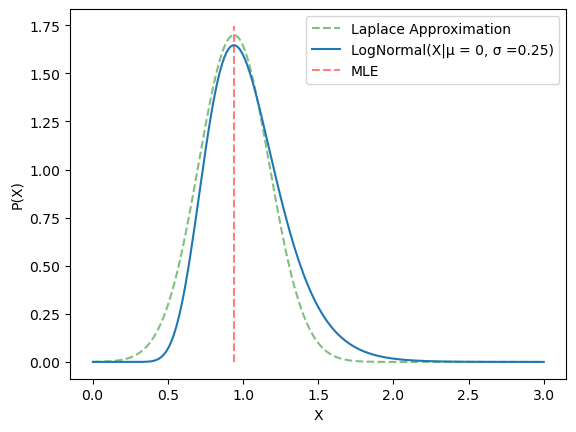

In [7]:
matplotlib.rcParams.update({'font.size': 10})
X = torch.linspace(0.001,3,200).unsqueeze(dim=0).T
σ = 0.25
μ = 0
P_X_LN = 1/(σ*X*np.sqrt(2*torch.pi))*torch.exp(-(torch.log(X) - μ)**2/(2*σ**2))

f = lambda x: -np.log(1/(σ*x[0]*np.sqrt(2*np.pi))*np.exp(-(np.log(x[0]) - μ)**2/(2*σ**2)))

out = minimize(f,method = 'L-BFGS-B', x0 = [2])
σ_Laplace = np.sqrt((out['hess_inv']).todense())

plt.plot(X,1/(σ_Laplace*np.sqrt(2*np.pi))*np.exp(-(X.numpy() - out['x'])**2/(2*σ_Laplace**2)),linestyle ='dashed',alpha = 0.5,color='g',label='Laplace Approximation')
plt.plot(X,P_X_LN,label='LogNormal(X|μ = 0, σ =0.25)')
plt.vlines(out['x'],0,max(P_X_LN)+0.1,linestyle ='dashed',alpha = 0.5,color='r',label='MLE')
plt.xlabel('X')
plt.ylabel('P(X)')
plt.legend()
plt.show()

The first step to actually computing the MAP estimate and the Hessian of the Laplace approximation is the distribution over the latent variable $\boldsymbol{f}$. Due to only requiring the MAP location we don't need to consider the denominator in $p(\boldsymbol{f} |\boldsymbol{X}, \boldsymbol{y}) = p(\boldsymbol{y}|\boldsymbol{f} )p(\boldsymbol{f} |\boldsymbol{X})/p(\boldsymbol{y}|\boldsymbol{X})$. Working with just $p(\boldsymbol{y}|\boldsymbol{f} )p(\boldsymbol{f} |\boldsymbol{X})$ we can take its logarithm and write out the terms directly. 

$$
{\Psi}(\boldsymbol{f}) = \log p(\boldsymbol{y}|\boldsymbol{f} ) + \log p(\boldsymbol{f} |\boldsymbol{X})
$$

Remebering that $p(\boldsymbol{f} |\boldsymbol{X}, \boldsymbol{y}) $ is the GP prior, and $p(\boldsymbol{y}|\boldsymbol{f} )$ is just a likelihood function, we can write $ p(\boldsymbol{f} |\boldsymbol{X})$ as the model evidence seen from the hyper parameter optimization of regular GPs.

$$
{\Psi}(\boldsymbol{f}) = \log p(\boldsymbol{y}|\boldsymbol{f} ) -\frac{1}{2}\boldsymbol{f}^T\boldsymbol{K}^{-1}\boldsymbol{f} - \frac{1}{2}\log|\boldsymbol{K}| - \frac{n}{2}\log2\pi
$$

Then differentiating with respect to $\boldsymbol{f}$ twice will give us the MAP estimate. 

$$
\nabla {\Psi}(\boldsymbol{f}) = \nabla \log p(\boldsymbol{y}|\boldsymbol{f} ) - \boldsymbol{K}^{-1}\boldsymbol{f} \\
\nabla \nabla  {\Psi}(\boldsymbol{f}) = \nabla \nabla  \log p(\boldsymbol{y}|\boldsymbol{f} ) - \boldsymbol{K}^{-1}
$$

This function has a unique property. Due to the initital posterior being log-concave, that means there is a unique maximum as well as the Hessian being positive definite. At this point, there are a few choices for the likelihood. I am going to stick with the choice I made earlier, the classic sigmoid.

$$
p(\boldsymbol{y}|\boldsymbol{f}) = \Pi_{n=1}^N \bigg(\frac{1}{1+\exp(-f_n)}\bigg)^{(y_n+1)/2}\bigg(1 -\frac{1}{1+\exp(-f_n)}\bigg)^{1 - (y_n+1)/2} \\
$$

For ease of calculation I am going to define $\boldsymbol{t} = (\boldsymbol{y}+1)/2$ which essetially just remaps the predicitions from -1 and 1 to 0 and 1. 

$$
p(\boldsymbol{y}|\boldsymbol{f}) = \Pi_{n=1}^N \bigg(\frac{1}{1+\exp(-f_n)}\bigg)^{t_n}\bigg(1 -\frac{1}{1+\exp(-f_n)}\bigg)^{1 - t_n} \\
= \Pi_{n=1}^N \exp(f_n t_n)\frac{1}{1+\exp(f_n)} \\
\implies \log p(\boldsymbol{y}|\boldsymbol{f}) = \sum_{n=1}^N f_n t_n - \log({1+\exp(f_n)})\\
\nabla \log p(\boldsymbol{y}|\boldsymbol{f}) = \boldsymbol{t} -  \frac{\exp(\boldsymbol{f})}{1+\exp(\boldsymbol{f})} = \boldsymbol{t} - \bigg(\frac{1}{1+\exp(-\boldsymbol{f})}\bigg) \\
\nabla \nabla  \log p(\boldsymbol{y}|\boldsymbol{f}) = - \bigg(\frac{1}{1+\exp(\boldsymbol{f})}\bigg) \circ \bigg(1 -\frac{1}{1+\exp(-\boldsymbol{f})}\bigg) \boldsymbol{I} = - \sigma(\boldsymbol{f})\circ(1-
\sigma(\boldsymbol{f})) \boldsymbol{I}
$$

Where $\circ$ denotes the elementwise product. To make things easier, we can again define a matrix $\boldsymbol{W}$

$$
\boldsymbol{W} = - \sigma(\boldsymbol{f})\circ(1-\sigma(\boldsymbol{f})) \boldsymbol{I} \\
\implies \nabla \nabla {\Psi}(\boldsymbol{f}) = - \boldsymbol{W} - \boldsymbol{K}^{-1}\\
\nabla {\Psi}(\boldsymbol{f}) =  \boldsymbol{t} - \sigma(\boldsymbol{f}) - \boldsymbol{K}^{-1}\boldsymbol{f}\\
$$

This results in an expression for the log probability, as well as its second derivative. As noted earlier, the is a convex problem. Meaning we can use the Newton-Raphson scheme to solve this. This implies an update equation of the form seen below. 

$$
\boldsymbol{f}_{new} = \boldsymbol{f} - \big(\nabla \nabla \Psi)^{-1}\nabla \Psi \\
 = \boldsymbol{f} + \big(\boldsymbol{W} + \boldsymbol{K}^{-1}\big)^{-1}\big(\boldsymbol{t} - \sigma(\boldsymbol{f}) - \boldsymbol{K}^{-1}\boldsymbol{f}\big)
$$

This process has then been coded below, without a hyper parameter optimization.

In [8]:
# This defines the hyper parmeters of the the Gaussian Process,
# 784 in length due to the pixel count in an image. 
ℓ = np.exp(2)*torch.ones(784)
w = np.exp(2.35)

# GPLR: Performs Gaaussian Process logistic regression on the inputs ϕ and their corresponding labels t.
# INPUTS
# ϕ := N x M matrix where N corresponds to the number of training samples and M is the dimensionality of the input vector
# t := N long vector of labels corresponding to training samples ϕ
# a_0 := N long vector of initial predictions for latent function values
# maxIterations := an integer corresponding to the max # of Newton-Raphson iterations.
# goalTolerance := a float corresponding to the stoppoing tolerance is max iterations isn't acheived.
#
# RETURNS
# a := N Long vector containing optimized latent function values for training set
# H := N x N matrix Hessian at MAP
# W := N x N matrix diagonal W matrix computed above, at the MAP
# grad := N long vector of the gradient of the likelihood at the MAP
# tolerance: Float of the final tolerance after Newton iteration. 
def GPLR(Φ,t,a_0,maxIterations = 100,goalTolerance = 1e-4):
    
    N = len(t)   # Number of samples 
    A = len(a_0) # Dimensonality of space
    
    a = a_0 # Initialize latent function guess to begin iterating
        
    invCn = torch.linalg.inv(K(Φ,Φ,ℓ,w))# + torch.diag(torch.ones(A)*1e-4)) # evaluate kernel matrix
    
    tolerance = 1
    iteration = 0
        
    while tolerance > goalTolerance and iteration < maxIterations:
        
        # Computes needed quantities for update
        σa = torch.sigmoid(a)
        W = torch.diag(σa*(1 - σa))
        gradE = t - σa -torch.matmul(invCn,a)
        H = W + invCn
        
        # Evaluate the update
        update = torch.matmul(gradE,torch.linalg.inv(H))
        
        # Update latent function values and use it to compute tolerance
        a = a - update
        tolerance = torch.sum(torch.abs(update))
        iteration += 1
    
    # Compute Hessian at the MAP for laplace approximation
    σa = torch.sigmoid(a)
    W = torch.diag(σa*(1 - σa))
    grad = t - σa
    H = W + invCn

    return a,H,W,grad,tolerance

The last important aspect of GP classification is utilizing the latent function values to compute predicitions for a new test data point. We can take the expectation of the gaussian process to compute the expectation of $f_*$ after training under $\boldsymbol{f}$.

$$
\mathbb{E}_{\text{Laplace}} = \boldsymbol{K}(\boldsymbol{X}_*,\boldsymbol{X})\boldsymbol{K}(\boldsymbol{X},\boldsymbol{X})\boldsymbol{f}
$$

In the scope of this notebook, we are not interested in the variance of the predicitions. Just which prediction is the most optimal. For further reading on this, check out Rasmussen and Williams.  Therefore we only need to plug this expectation through the sigmoid to get predictions. Hence:

$$
\pi_{*\text{MAP}} = \sigma\big(\boldsymbol{K}(\boldsymbol{X}_*,\boldsymbol{X})\boldsymbol{K}(\boldsymbol{X},\boldsymbol{X})\boldsymbol{f}\big)
$$

In [9]:
# π_approx: Computes the MAP prediction of π_*
# X_test: J by M Matrix of the data points meant to be infered.  
# X_train: N by M Matrix of the training data used to compute the latent function values
# grad: N long vector of the gradient of the likelihood at the MAP
def π_approx(X_test,X_train,grad):
    Kid = K(X_test,X_train,ℓ,w)
    fstar = torch.matmul(Kid,grad)
    return torch.sigmoid(fstar) 

In [10]:
# Use the data loader to create a set of training and testing datapoints for the GP

for i,(inputs,labels) in enumerate(loader):
    # Save the training data set
    if i == 0:
        Y_Train = labels.squeeze(dim=1)
        X_Train = inputs.squeeze(dim=1).flatten(start_dim=1)
    # Save the testing data set
    elif i == 1: 
        Y_Test = labels.squeeze(dim=1)
        X_Test = inputs.squeeze(dim=1).flatten(start_dim=1)
    # Break away 
    else:
        break

In [11]:
# Compute latent function values MAP estimate along with other quantities. 
a,H,W,grad,tolerance = GPLR(X_Train,Y_Train,torch.ones(len(X_Train)))
# Compute MAP π predictions.
π = π_approx(X_Test.unsqueeze(dim=0),X_Train,grad)[0]
# Use that to make a decision based of the 0.5 boundary
π[π >= 0.5] = 1
π[π < 0.5] = 0

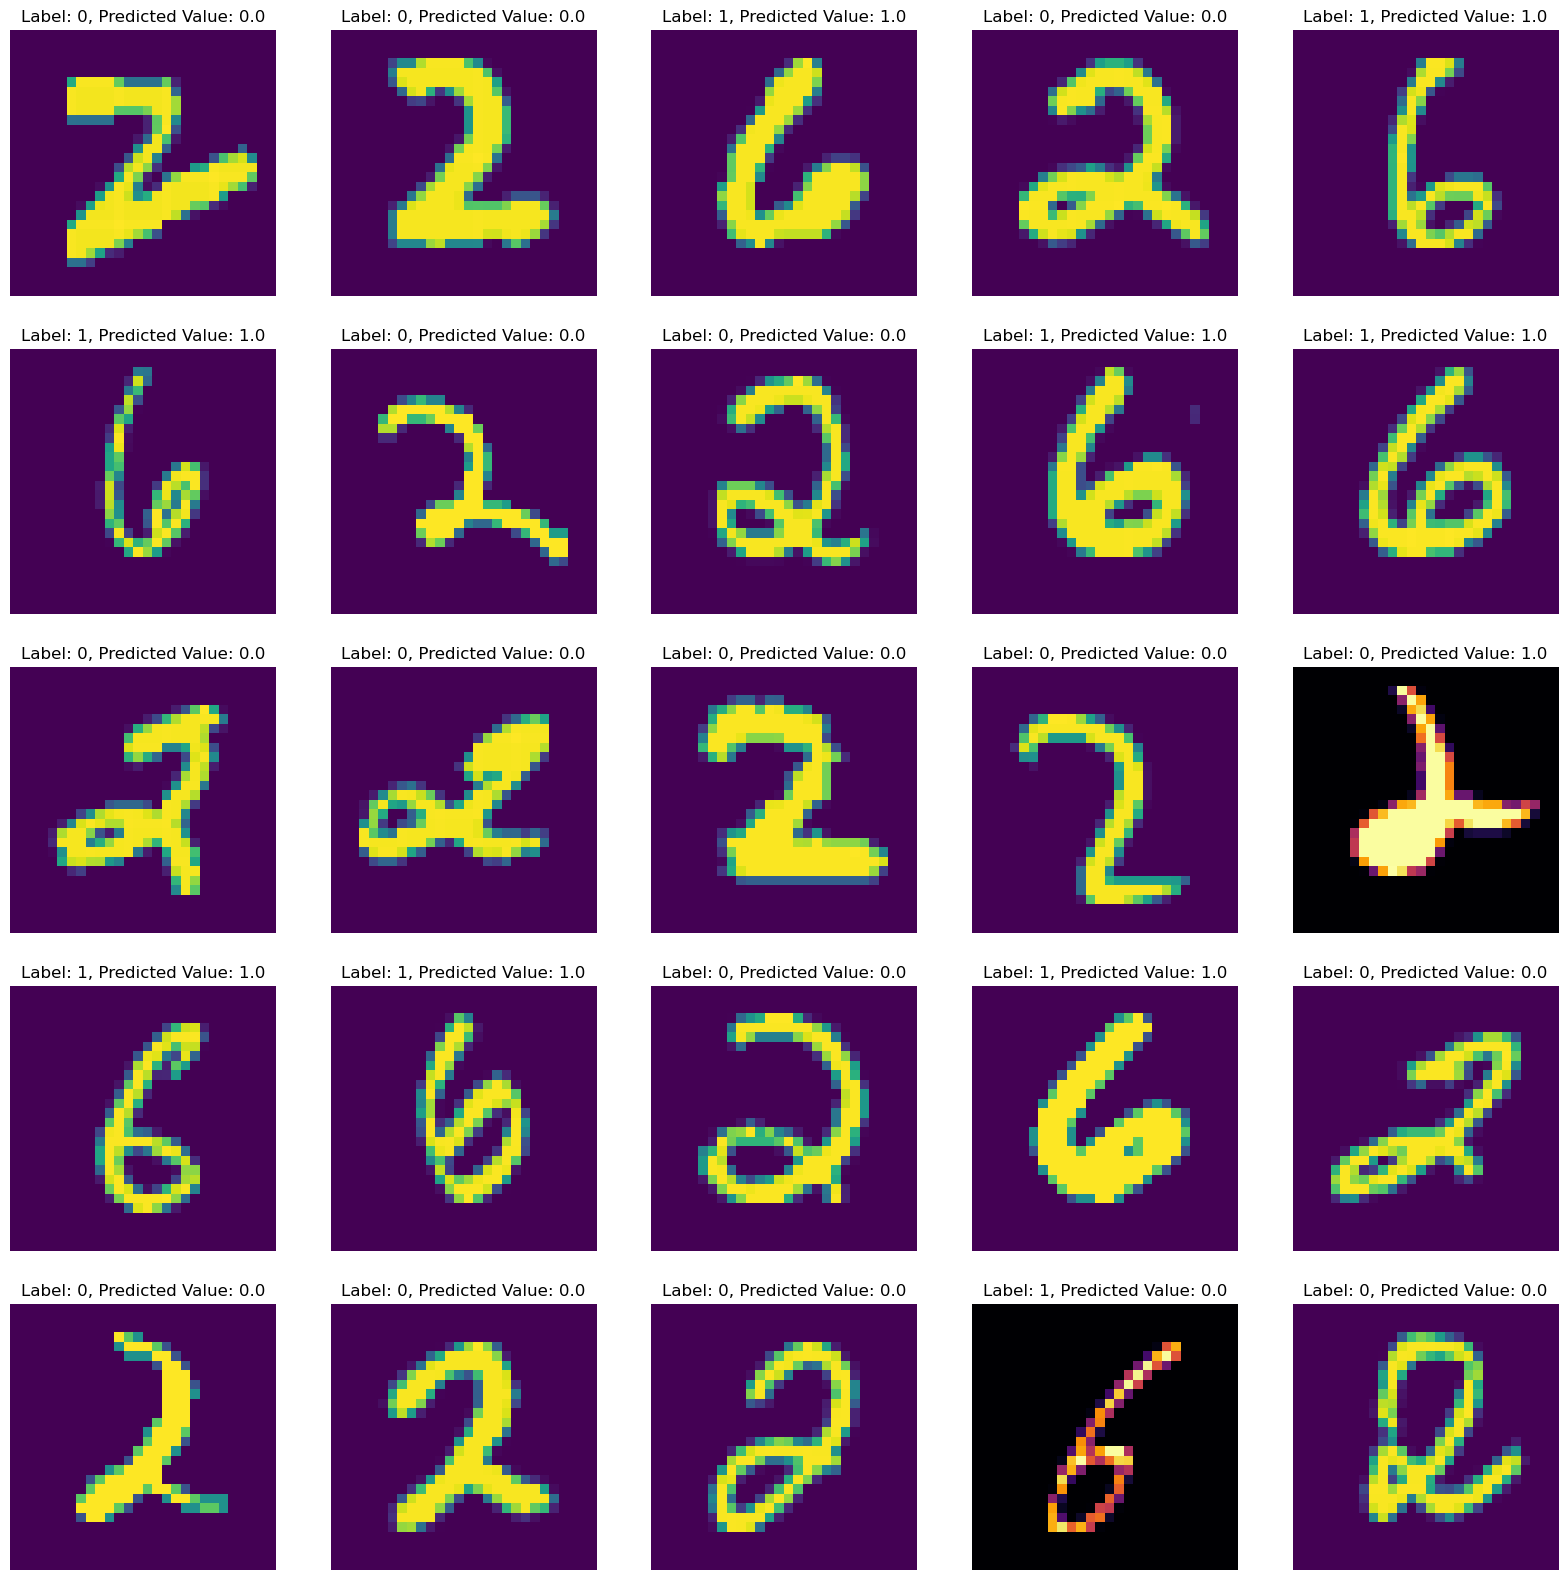

% Predictive Acccuracy:  94.66666653752327


In [12]:
# Plots some results. Alternate inferno color means it failed. 
fig,ax  = plt.subplots(5,5,figsize=(20,20))
idx = 0
for i in range(5):
    for j in range(5):
        if Y_Test[idx].item() != π[idx].item():
            ax[j][i].imshow(X_Test[idx].reshape(28,28),cmap="inferno")
        else:
            ax[j][i].imshow(X_Test[idx].reshape(28,28))
        ax[j][i].set_title("Label: " + str(Y_Test[idx].item())  + ", Predicted Value: " + str(π[idx].item()))
        ax[j][i].axis('off')
        idx+=1
plt.show()        
print("% Predictive Acccuracy: ",100 - 100*(torch.sum(torch.abs(π - Y_Test))/len(π)).item())